In [3]:
import os
import numpy as np
from tqdm import tqdm
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras import Model
from keras.callbacks import Callback
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.layers import (
    Input,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    concatenate,
    Dropout,
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

/home/yifan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-03-30 23:37:23.045345: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-30 23:37:23.052869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743403043.061472  202048 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory f

In [4]:
image_path = "../temp/training/Images/"
mask_path = "../temp/training/Masks/"
SIZE = 128

In [5]:
# lists of images and masks names
image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

images = np.zeros(shape=(len(image_names), SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names), SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
    path = image_path + image_names[id]
    img = np.asarray(Image.open(path)).astype("float") / 255.0
    img = cv.resize(img, (SIZE, SIZE), cv.INTER_AREA)
    images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
    path = mask_path + mask_names[id]
    mask = np.asarray(Image.open(path)).astype("float") / 255.0
    mask = cv.resize(mask, (SIZE, SIZE), cv.INTER_AREA)
    masks[id] = mask[:, :, :1]

Mask: 100%|██████████| 4320/4320 [00:13<00:00, 324.54it/s] 


In [6]:
# Train test split
# images_train, images_test, mask_train, mask_test = train_test_split(images, masks, test_size=0.01)

# Train test split with no images left for testing
images_train = images
images_test = []
mask_train = masks
mask_test = []

print(f"Train images: {len(images_train)}")
print(f"Test images: {len(images_test)}")

Train images: 4320
Test images: 0


In [7]:
# Define U-net architecture
def unet_model(input_layer, start_neurons):
    # Contraction path
    conv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons*16, kernel_size=(3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons*16, kernel_size=(3, 3), activation="relu", padding="same")(convm)
    
    # Expansive path
    deconv4 = Conv2DTranspose(start_neurons*8, kernel_size=(3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons*8, kernel_size=(3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*4, kernel_size=(3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons*4, kernel_size=(3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*2, kernel_size=(3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons*2, kernel_size=(3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons*1, kernel_size=(3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons, kernel_size=(3, 3), activation="relu", padding="same")(uconv1)
    
    # Last conv and output
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [8]:
# Compile unet model
input_layer = Input((SIZE, SIZE, 3))
output_layer = unet_model(input_layer = input_layer, start_neurons = 16)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
# model.summary()

I0000 00:00:1743403072.205543  202048 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9653 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1


In [9]:
def create_augmented_data_generators(images, masks, batch_size=32, seed=42):
    # Create a single augmentation configuration
    data_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Use the flow method that takes both x and y
    augmented_generator = data_gen.flow(
        x=images,
        y=masks,
        batch_size=batch_size,
        seed=seed,
        shuffle=True
    )
    
    return augmented_generator

In [10]:
# Training
epochs = 100
batch_size = 32

# Create the augmented data generator
augmented_data_generator = create_augmented_data_generators(
    images_train, 
    mask_train, 
    batch_size=batch_size
)

In [11]:
# Post Process
def mask_threshold(image, threshold=0.25):
    return image > threshold


# Modified ShowProgress callback with its own generator
class ShowProgress(Callback):
    def __init__(self, images, masks, save=False):
        self.save = save
        self.images = images
        self.masks = masks
        # Create a dedicated generator just for visualization
        self.visualization_generator = create_augmented_data_generators(
            images, masks, batch_size=1, seed=123
        )

    def on_epoch_end(self, epoch, logs=None):
        # Get a batch from our dedicated visualization generator
        batch_images, batch_masks = next(self.visualization_generator)
        
        # Since batch size is 1, we don't need to select a random index
        original_image = batch_images
        predicted_mask = self.model.predict(original_image).reshape(128, 128)
        proc_mask02 = mask_threshold(predicted_mask, threshold=0.2)
        proc_mask03 = mask_threshold(predicted_mask, threshold=0.3)
        proc_mask04 = mask_threshold(predicted_mask, threshold=0.4)
        proc_mask05 = mask_threshold(predicted_mask, threshold=0.5)
        mask = batch_masks[0].reshape(128, 128)

        plt.figure(figsize=(15, 10))

        plt.subplot(1, 7, 1)
        plt.imshow(original_image[0])
        plt.title("Original Image (Augmented)")

        plt.subplot(1, 7, 2)
        plt.imshow(predicted_mask, cmap="gray")
        plt.title("Predicted Mask")

        plt.subplot(1, 7, 3)
        plt.imshow(mask, cmap="gray")
        plt.title("Original Mask (Augmented)")

        plt.subplot(1, 7, 4)
        plt.imshow(proc_mask02, cmap="gray")
        plt.title("Processed: 0.2")

        plt.subplot(1, 7, 5)
        plt.imshow(proc_mask03, cmap="gray")
        plt.title("Processed: 0.3")

        plt.subplot(1, 7, 6)
        plt.imshow(proc_mask04, cmap="gray")
        plt.title("Processed: 0.4")

        plt.subplot(1, 7, 7)
        plt.imshow(proc_mask05, cmap="gray")
        plt.title("Processed: 0.5")

        plt.tight_layout()
        plt.show()

Epoch 1/100


/home/yifan/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1743403075.142158  202233 service.cc:148] XLA service 0x7f594c0369e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743403075.142173  202233 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-03-30 23:37:55.203414: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743403075.519877  202233 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-30 23:37:55.973419: I external/local_xla/x

  3/135 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.7166 - loss: 0.6716 

2025-03-30 23:38:03.913958: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_transpose_fusion_4', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_transpose_fusion', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1743403083.942822  202233 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7002 - loss: 0.5375

2025-03-30 23:38:09.994537: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,128,128]{3,2,1,0}, f32[16,3,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-03-30 23:38:10.017617: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[1,16,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,16,128,128]{3,2,1,0}, f32[16,16,3,3]{3,2,1,0}, f32[16]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step


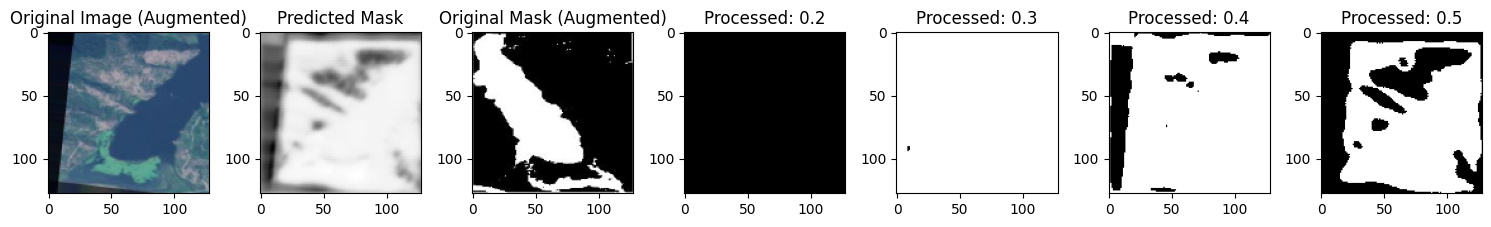

135/135 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.7002 - loss: 0.5370
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2025-03-30 23:38:10.807339: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-03-30 23:38:10.807368: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2025-03-30 23:38:10.807380: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9456048006659202720
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


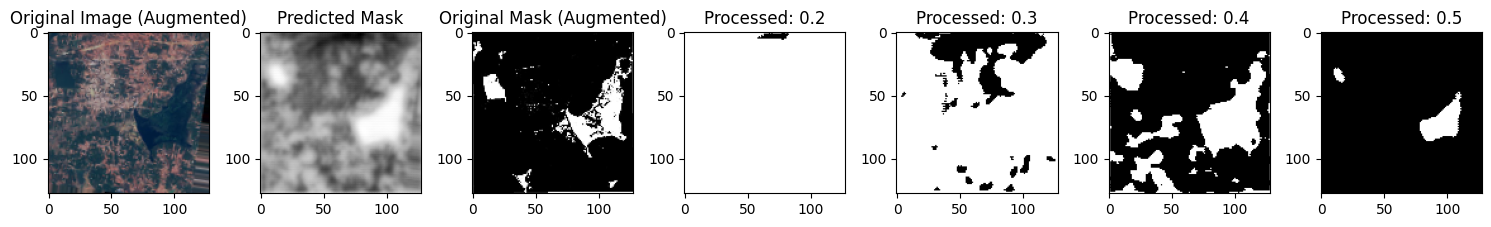

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.7222 - loss: 0.40


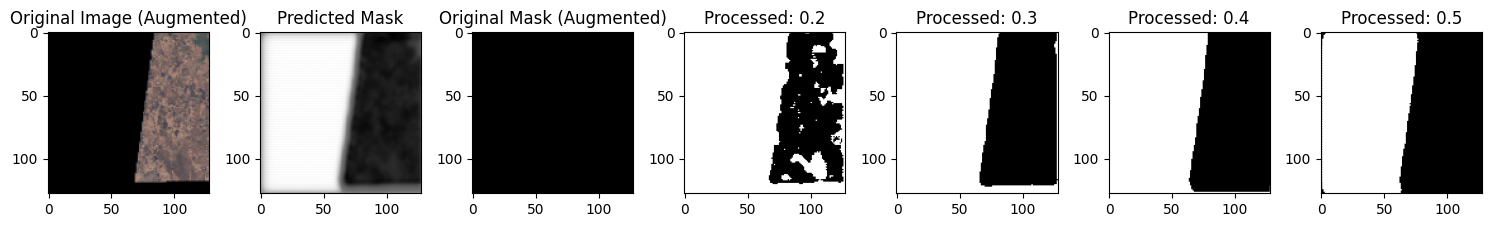

135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7223 - loss: 0.4072
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2025-03-30 23:38:17.339582: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


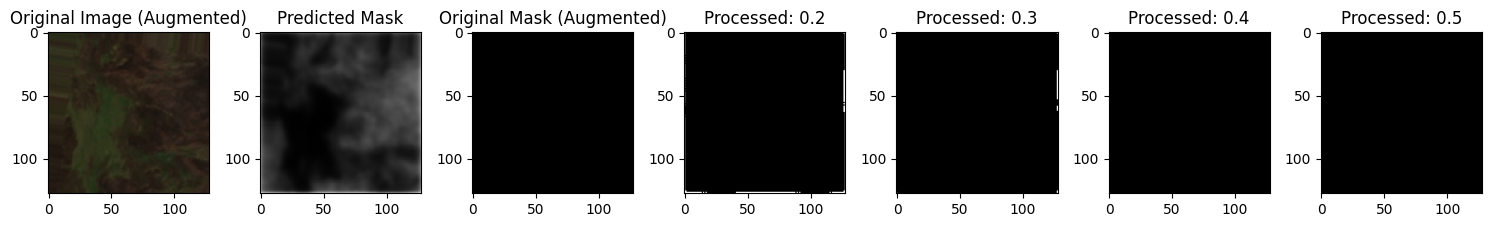

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.7239 - loss: 0.40


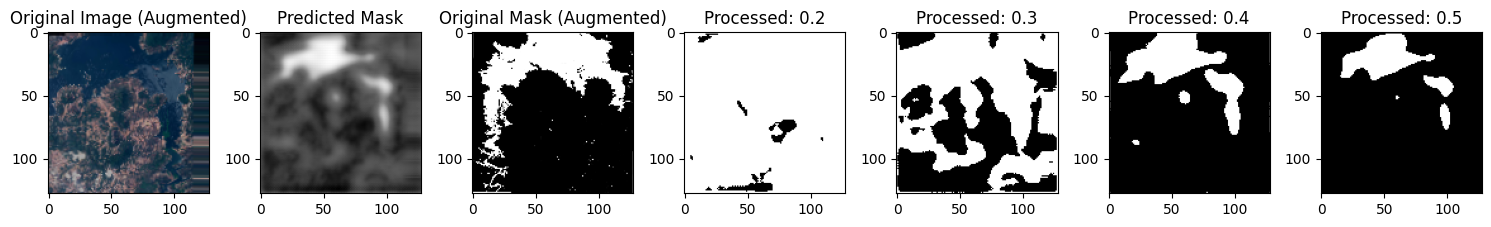

135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7240 - loss: 0.4036
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


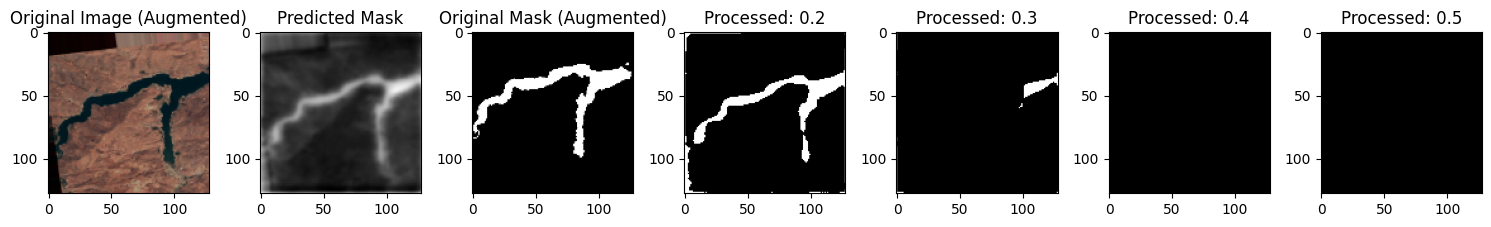

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step/step - accuracy: 0.7377 - loss: 0.39


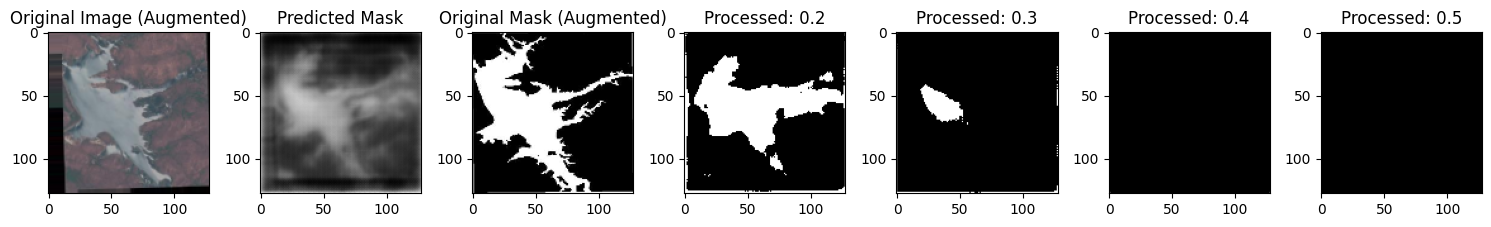

135/135 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7377 - loss: 0.3900
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


2025-03-30 23:38:30.619950: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


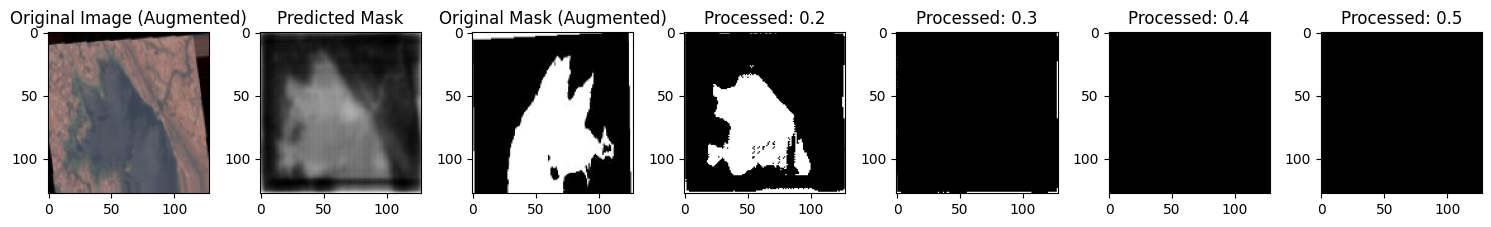

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/100
131/135 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7340 - loss: 0.3883

KeyboardInterrupt: 

In [12]:
# Calculate steps per epoch based on the dataset size and batch size
steps_per_epoch = len(images_train) // batch_size

# Training with augmentation - pass images and masks to the callback
history = model.fit(
    augmented_data_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=[ShowProgress(images_train, mask_train)],  # Pass data to the callback
)

In [ ]:
from datetime import datetime

# Get the current date and time
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Save the model with the current date and time in the filename
model.save(f'../models/{current_time}.keras')